<h1> Customer Segmentation Analysis </h1>

<b> Objective :</b> Analyze customer shopping pattern to create different segments or groups of customers.

In [303]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [304]:
raw = pd.read_csv('Online Retail.csv',encoding="ISO-8859-1")
raw.InvoiceDate = pd.to_datetime(raw["InvoiceDate"])
raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [305]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [306]:
#As seen from above, there are missing values in customerID so lets filter those records

raw=raw[pd.notnull(raw.CustomerID)]

#There do exist some bad records where the quanity is in negative which is can not be true so lets filter them out

raw = raw[raw.Quantity>0]

<h3>Before we create the clusters, let's perform exploratory data analysis on the given dataset</h3>

In [307]:
#Question: Which country has the highest number of online orders?
#Answer: United Kingdom has almost 91% of total orders.

freq = raw.groupby('Country').InvoiceNo.count().sort_values(ascending=False)

freq1 = pd.DataFrame(freq)
freq1.iloc[:,:1].apply(lambda x: x*100/sum(x))

,InvoiceNo
Country,
United Kingdom,89.048411
Germany,2.272293
France,2.096380
EIRE,1.818940
Spain,0.624491
Netherlands,0.593832
Belgium,0.510399
Switzerland,0.462902
Portugal,0.367407


In [308]:
#Question 2: Which day of the week or month had the most number of order 

raw2=pd.DataFrame(data=np.ones(raw.iloc[:,:1].shape,dtype=int),index=raw.InvoiceDate)
raw2.rename(columns={0:'count'},inplace=True)

In [309]:
raw2['month'] = [x.month for x in raw2.index]
raw2['day'] = [x.day for x in raw2.index]
raw2['hour'] = [x.hour for x in raw2.index]

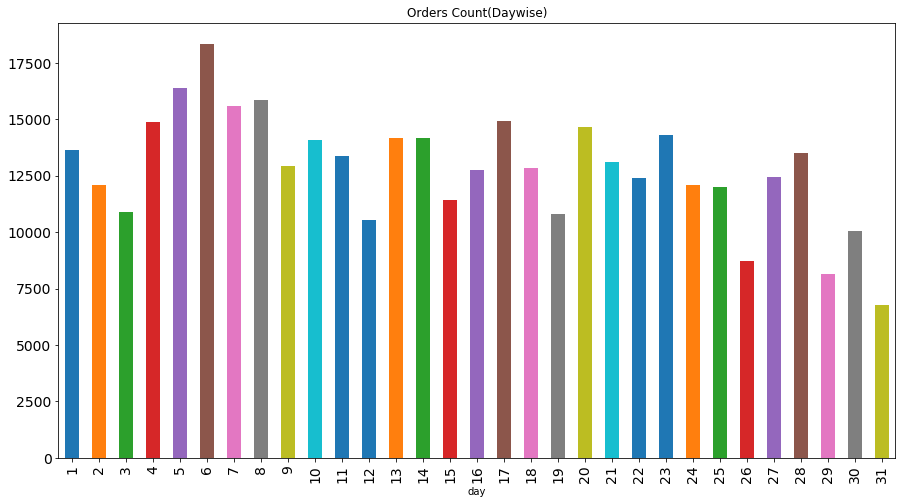

In [310]:
raw2.groupby('day')['count'].sum().plot.bar(figsize=(15,8), title= 'Orders Count(Daywise)', fontsize=14)

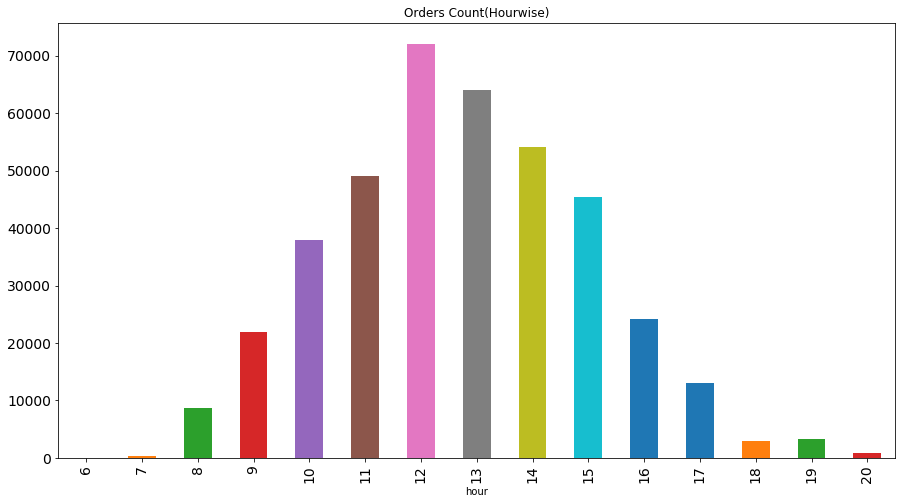

In [311]:
raw2.groupby('hour')['count'].sum().plot.bar(figsize=(15,8), title= 'Orders Count(Hourwise)', fontsize=14)

<h3> Now lets work on segmentation below </h3>

<b> Approach: </b>

Before creating the customer segmentation we need to assign scores to individual customers based on which we would be creating the clusters. The score would be assigned using RFM analysis. RFM can be described as:

<> Recency — How recently did the customer purchase?<br>
<> Frequency — How often do they purchase?<br>
<> Monetary Value — How much do they spend?<br>


To calculate Recency, we’ll look into the invoice dates. Since the date of our last invoice was 2011–12–09, we’ll consider it as the most recent one. Then, we’ll subtract each day from the day after to calculate the other ‘recencies’.

To calculate frequency, we’ll simply sum the invoice numbers for each customer. For the monetary value, we will multiply the unitary price by the quantity bought and sum them for each client.

To calculate the monetary value, we'll simply calculate the total price by multiplying the unit price and quantity per transaction and then we would aggregate it by customer to get the total monetary value per customer.


In [312]:
max_date= raw.InvoiceDate.max()

raw['Total_Price'] = raw.UnitPrice * raw.Quantity

In [313]:
raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [314]:
#Let's create the RFM values for the given dataframe

raw_agg=raw.groupby('CustomerID').agg({'InvoiceDate': lambda x: (max_date - max(x)).days,
                              'InvoiceNo': lambda x:len(x),
                              'Total_Price': lambda x:round(x.sum(),2)})

raw_agg.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','Total_Price':'Monetary_Value'},inplace=True)

raw_agg.head()

,Recency,Frequency,Monetary_Value
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


Till now we created the features RFM, now let's assign a score value to those RFM to signifiy their importance per customer. Scores are calculated as below:

Recency: The scores are calculated from 1-5 where 5 represents very recently bought item whereas 1 represents item bought long time back. For this we would sort the whole population in ascending order of recency and divide the whole population into a group of 5. Then simply assign numbers from 1-5 to those groups.

Frequency & Monetary value: The scores are calculated in similar fashion for this too. But as higher is better in these features, we would sort the values in descending order and then assign the scores from 1-5 by dividing the population in 5 equal parts.

In [315]:
# Create f_score

f_score = []
m_score = []
r_score = []
rfmTable=raw_agg

columns = ['Frequency', 'Monetary_Value']
scores_str = ['f_score', 'm_score']
scores = [f_score, m_score]

for n in range(len(columns)):
    # Order by column
    rfmTable = rfmTable.sort_values(columns[n], ascending=False)
    
    # Create new index
    refs = np.arange(1,4340)
    rfmTable['refs'] = refs
    
    # Add score
    for i, row in rfmTable.iterrows():
        if row['refs'] <= 866:
            scores[n].append(5)
        elif row['refs'] > 866 and row['refs'] <= 866*2:
            scores[n].append(4)
        elif row['refs'] > 866*2 and row['refs'] <= 866*3:
            scores[n].append(3)
        elif row['refs'] > 866*3 and row['refs'] <= 866*4:
            scores[n].append(2)
        else: 
            scores[n].append(1)

    # Create f_score column
    rfmTable[scores_str[n]] = scores[n]
    
# For recency, we do the opposite: most recents are better, so we order as ascending
rfmTable = rfmTable.sort_values('Recency', ascending=True)
    
# Recreate index
refs = np.arange(1,4340)
rfmTable['refs'] = refs
    
# Add score
for i, row in rfmTable.iterrows():
    if row['refs'] <= 866:
        r_score.append(5)
    elif row['refs'] > 866 and row['refs'] <= 866*2:
        r_score.append(4)
    elif row['refs'] > 866*2 and row['refs'] <= 866*3:
        r_score.append(3)
    elif row['refs'] > 866*3 and row['refs'] <= 866*4:
        r_score.append(2)
    else: 
        r_score.append(1)

# Create f_score column
rfmTable['r_score'] = r_score
    
rfmTableScores = rfmTable.drop(['Frequency', 'Monetary_Value', 'Recency', 'refs'], axis=1)

rfmTableScores.head(5)

,f_score,m_score,r_score
CustomerID,,,
13318.0,2,3,5
16833.0,3,4,5
14621.0,4,4,5
13521.0,5,4,5
13510.0,4,4,5


<h3> Lets create the clusters using k-means </h3>

In [316]:
raw_kmeans= rfmTableScores[['r_score','f_score','m_score']]

In [317]:
from sklearn.cluster import KMeans

In [318]:
#As all our scores are on the same scale from 1 to 5, we do not perform any additional scaling operation on the dataset

wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',random_state=0)
    kmeans.fit(raw_kmeans)
    wcss.append(kmeans.inertia_)

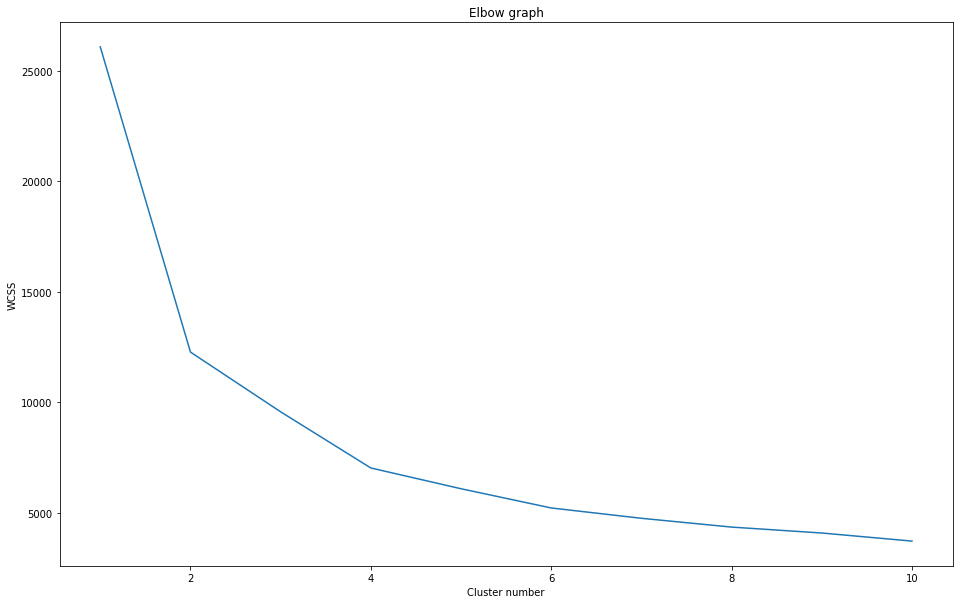

In [319]:
plt.figure(figsize=(16,10))
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

In [320]:
#from above plot we can see that after cluster 4-5 the error gets almost 0, thus we would pick k as 4 clusters.

kmeans = KMeans(n_clusters=4,init='k-means++',random_state=0)
clusters = kmeans.fit_predict(raw_kmeans)

In [321]:
rfmTable['cluster']=clusters


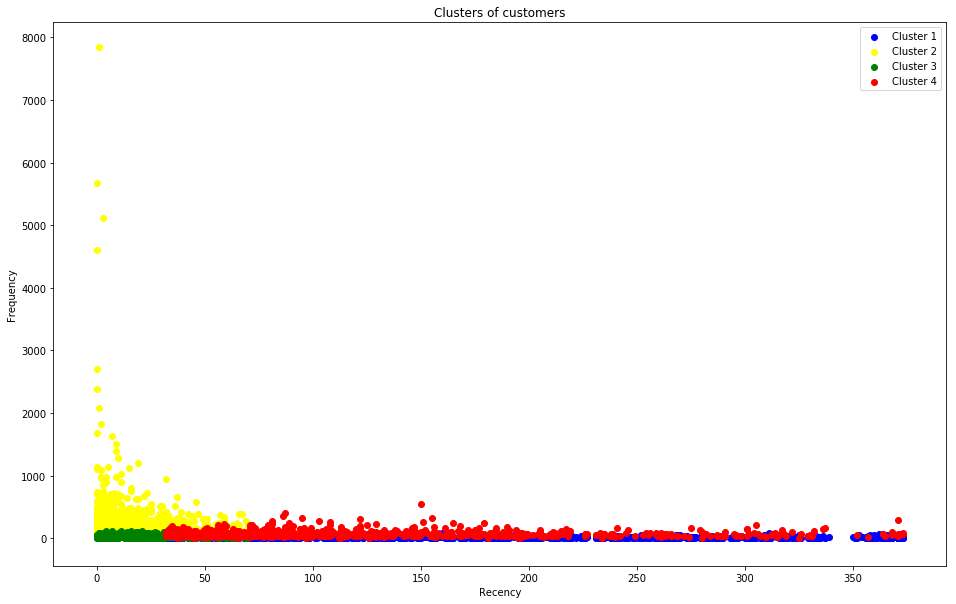

In [322]:
#Let's visualize the clusters to understand the segmentation


c1 = rfmTable[rfmTable.cluster == 0]
c2 = rfmTable[rfmTable.cluster == 1]
c3 = rfmTable[rfmTable.cluster == 2]
c4 = rfmTable[rfmTable.cluster == 3]

plt.figure(figsize=(16,10))

plt.scatter(c1.Recency, c1.Frequency, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.Recency, c2.Frequency, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.Recency, c3.Frequency, c = 'green', label = 'Cluster 3')
plt.scatter(c4.Recency, c4.Frequency, c = 'red', label = 'Cluster 4')

plt.title('Clusters of customers')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()

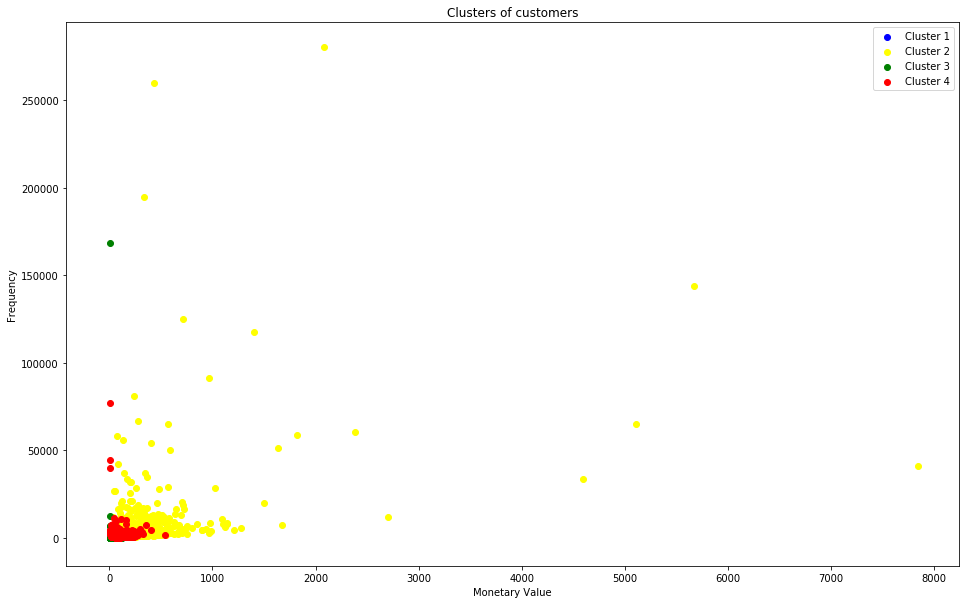

In [323]:
c1 = rfmTable[rfmTable.cluster == 0]
c2 = rfmTable[rfmTable.cluster == 1]
c3 = rfmTable[rfmTable.cluster == 2]
c4 = rfmTable[rfmTable.cluster == 3]

plt.figure(figsize=(16,10))

plt.scatter( c1.Frequency, c1.Monetary_Value,c = 'blue', label = 'Cluster 1')
plt.scatter( c2.Frequency,c2.Monetary_Value, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.Frequency,c3.Monetary_Value, c = 'green', label = 'Cluster 3')
plt.scatter(c4.Frequency,c4.Monetary_Value, c = 'red', label = 'Cluster 4')

plt.title('Clusters of customers')
plt.xlabel('Monetary Value')
plt.ylabel('Frequency')
plt.legend()

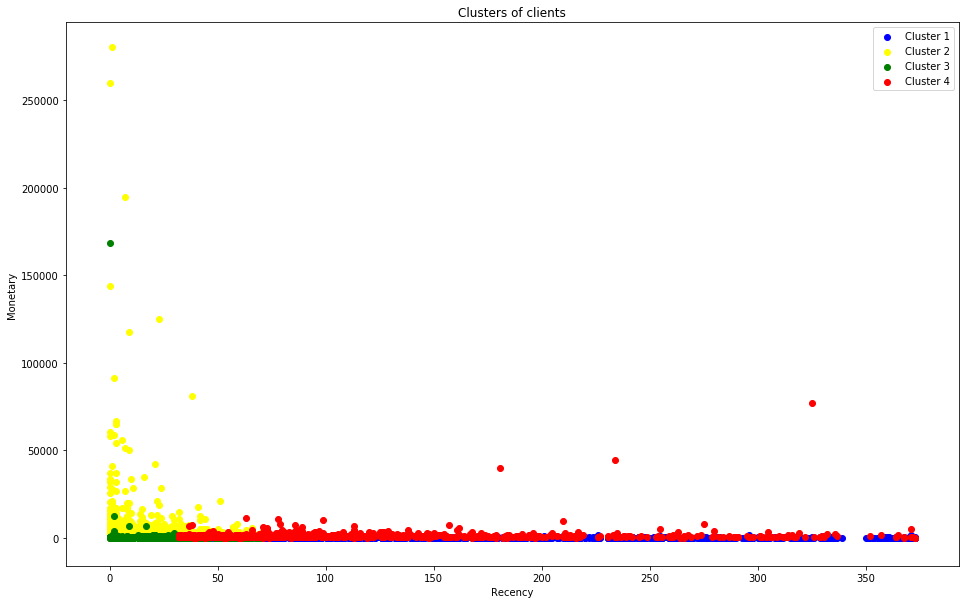

In [324]:
c1 = rfmTable[rfmTable.cluster == 0]
c2 = rfmTable[rfmTable.cluster == 1]
c3 = rfmTable[rfmTable.cluster == 2]
c4 = rfmTable[rfmTable.cluster == 3]

plt.figure(figsize=(16,10))

plt.scatter(c1.Recency, c1.Monetary_Value, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.Recency, c2.Monetary_Value, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.Recency, c3.Monetary_Value, c = 'green', label = 'Cluster 3')
plt.scatter(c4.Recency, c4.Monetary_Value, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()

<h3> Conclusion: </h3>
   From the above plots we can conclude that customers in cluster 2 and 3 are our ideal loyal customer who have shopped recently , frequently and also have contributed well to the monetary value. However we would need to focus more on customers from cluster 1 & 4 to engage them more and understand their needs separately.


<h3> Who are our top 10 customers? </h3>
Answer: Below mentioned are our top 10 customers there cluster number is actually 2 as numerically they are from 0-3

In [343]:
rfmTable[(rfmTable['f_score']== 5 ) & (rfmTable['m_score'] == 5) &(rfmTable['r_score'] == 5)].sort_values('Monetary_Value',ascending=False).head(10)

,Recency,Frequency,Monetary_Value,refs,f_score,m_score,r_score,cluster
CustomerID,,,,,,,,
14646.0,1,2080,280206.02,148,5,5,5,1
18102.0,0,431,259657.30,78,5,5,5,1
17450.0,7,337,194550.79,577,5,5,5,1
14911.0,0,5677,143825.06,91,5,5,5,1
14156.0,9,1400,117379.63,671,5,5,5,1
17511.0,2,963,91062.38,208,5,5,5,1
16684.0,3,277,66653.56,280,5,5,5,1
14096.0,3,5111,65164.79,275,5,5,5,1
13694.0,3,568,65039.62,273,5,5,5,1
